## 引入文件和分析大类编号的分布

<AxesSubplot:xlabel='大类编号', ylabel='count'>

d:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


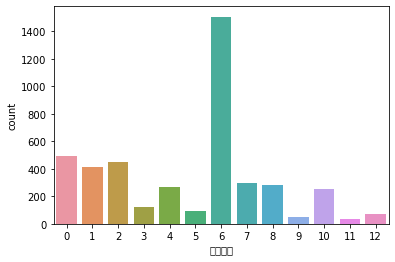

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
data = pd.read_json('data_de_identified.json')
# data.head()
data = data[["大类编号","简要案情"]]
data["大类编号"].value_counts()
sns.countplot(data=data, x='大类编号')

## 去除时间和字符等

In [2]:
import re
def pre_rm(text):
    # 统一日期格式
    text = text.replace("年", "-").replace("月", "-").replace("日", "-").replace("时", "-").replace("分", " ").strip()
    text = re.sub("\s+", "", text)
    # 2022年6月14日18时01分许 "2022年6月7日" "2014年5月"
    # [^\u4e00-\u9fa5]  除去字符
    regex_list = [r"(\d{4}-\d{1,2}-\d{1,2}-\d{1,2}-\d{1,2})|(\d{4}-\d{1,2}-\d{1,2})|(\d{4}-\d{1,2})",
                  r"[_.!+-=——,$%^，：“”（）:。？、~@#￥%……&*《》<>「」{}【】()/]",
                 ]
    for regex in regex_list:
        pattern = re.compile(regex)
        no_date = re.sub(pattern,'',text)
    return no_date

data["简要案情"] = data["简要案情"].apply(lambda x: pre_rm(x))
data.head() 
data.to_csv("demo1.csv")

## 分词+引入停用词表

In [3]:
import jieba
data = pd.read_csv('demo1.csv')
def get_stopword_list(file):
    with open(file, 'r', encoding='utf-8') as f:    
        stopword_list = [word.strip('\n') for word in f.readlines()]
    return stopword_list
# def segment(train_data):
#     train_data["简要案情"].apply(lambda x:' '.join(jieba.cut(x)))
#     print(train_data["简要案情"].head())
#     return train_data
def seg_sentence(list_text,stopword_list):
    seg_text = [ w for w in list_text if w not in stopword_list]
    return seg_text
# 分词
data["简要案情"] = data["简要案情"].apply(lambda x:' '.join(jieba.cut(x)))

data.to_csv("demo2.csv")

#引入
stopword_list = get_stopword_list('cn_stopwords.txt')

print(type(data["简要案情"][0]))
print(data["简要案情"][0])
# 去停用词还没解决,不这样干了
# data['简要案情'].apply(lambda x:seg_sentence(list(x), stopword_list))
# data.head()

Building prefix dict from the default dictionary ...
Loading model from cache D:\temp\jieba.cache
Loading model cost 0.541 seconds.
Prefix dict has been built successfully.


<class 'str'>
事主 身份证 电话 银行 信息 QQ 账号 于 许当 其 在 就 接到 一个 电话 对方 就 称 其 是 京东 物流 对方 说 其 在 拼 多多 上 买 的 沙发 输运 中 不见 了 要 赔偿 给 其 其 就 说好 对方 就 跟 其 说 他 只是 客服 没有 退款 的 权限 等 下会 有 经理 会 联系 其过 了 一会 其 就 收 一个 电话 对方 称 他 是 京东 物流 经理 因为 其 与 他 聊天 断断续续 其 就 下楼 过去 物业管理 处 前台 看 信号 会 不会 好点 因为 信号 不好 对方 就 称 添加 其 的 QQ 账号 对方 账户 对方 在 QQ 里面 就 发 了 一个 二维码 给 其 扫描 并 声称 这个 是 对方 的 客服 聊天 软件 需要 支付宝 扫描 其 使用 支付宝 扫描 之后 就 有 一个 在线 客服 指引 对方 称其要 退款 就 需要 其 付款 购买 沙发 的 建设银行 银行卡 内 的 余额 转入 其 提供 给 其 的 银行卡 内 建设银行 账户 账号 到 候会 一次性 加上 赔偿款 打回 其 的 卡内 其 就 按照 对方 的 指示 将 其 建设 银行卡 内 的 元 人民币 转入 了 对方 提供 的 银行卡 内过 了 一会 对方 又 说 不行 说 其 银监会 身份 认证 失败 需要 其 的 招商银行 的 钱 也 转 进去 这其 就 清醒 了 随后 物业 的 人 就 带 其来 派出所 了 其 一共 被 骗 元 人民币 对方 联系电话 ； 对方 银行 信息 建设银行 账户 账号 对方 QQ 账号


## tfidf计算词频

In [4]:
terms = data["简要案情"].tolist()
y = data["大类编号"].tolist()

from sklearn.feature_extraction.text import TfidfVectorizer as TFIV
# 初始化TFIV对象，去停用词，加2元语言模型
 
tfv = TFIV(max_df=0.4,  max_features=500, strip_accents='unicode', analyzer='word',token_pattern=r"(?u)\b\w+\b",
           ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1, stop_words = stopword_list)
tfv.fit(terms)
X_all = tfv.transform(terms)
X_all.todense()
tfv.vocabulary_

d:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['若果'] not in stop_words.
  warnings.warn(


{'事主': 59,
 '身份证': 426,
 '电话': 336,
 '信息': 87,
 'qq': 5,
 '接到': 267,
 '京东': 63,
 '说': 411,
 '买': 57,
 '中': 42,
 '客服': 182,
 '没有': 310,
 '退款': 457,
 '会': 74,
 '联系': 385,
 '聊天': 383,
 '信号': 85,
 '添加': 319,
 '里面': 466,
 '发': 146,
 '二维码': 60,
 '扫描': 243,
 '软件': 445,
 '需要': 491,
 '支付宝': 284,
 '使用': 81,
 '之后': 56,
 '指引': 261,
 '付款': 69,
 '购买': 419,
 '建设银行': 206,
 '余额': 78,
 '转入': 432,
 '提供': 272,
 '指示': 262,
 '建设': 204,
 '人民币': 66,
 '身份': 425,
 '认证': 400,
 '招商银行': 256,
 '钱': 471,
 '转': 429,
 '进去': 452,
 '派出所': 313,
 '一共': 15,
 '联系电话': 387,
 '接到 一个': 268,
 '一个 电话': 11,
 '电话 称': 337,
 '添加 qq': 320,
 '提供 银行卡': 275,
 '建设 银行卡': 205,
 '元 人民币': 94,
 '骗 元': 495,
 '报称': 251,
 '自称': 390,
 '无法': 290,
 '现': 327,
 '进行': 453,
 '刷': 129,
 '流水': 314,
 '方式': 289,
 '转完': 434,
 '诈骗': 406,
 '记录': 402,
 '名下': 163,
 '工商': 194,
 '卡号': 142,
 '电话号码': 339,
 '报案人': 250,
 '农业': 120,
 '客服 电话': 183,
 '无法 提供': 291,
 '银行卡 转账': 480,
 '转账 元': 438,
 '工商 银行卡': 195,
 '银行卡 卡号': 475,
 '农业 银行卡': 121,
 '银行卡 号': 476,
 '许': 403,
 '公安

## 分类模型前的特征选择：将文本进行特征表示后，还进行特征选择，选出较优的特征。

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
# 卡方检验选取100个特征
select_feature_model = SelectKBest(chi2, k=100)
X_all= select_feature_model.fit_transform(X_all, y)

## 分训练和测试集

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_all, y, random_state=1)

## 朴素贝叶斯

In [7]:
from sklearn.naive_bayes import MultinomialNB
model_NB = MultinomialNB()
# 模型训练
model_NB.fit(x_train, y_train)
print(model_NB.score(x_test, y_test))

from sklearn.model_selection import cross_val_score
#评估预测性能，减少过拟合
# for cv in range(5,25):  20
print("knn分类器20折交叉验证得分: ", np.mean(cross_val_score(model_NB, x_train, y_train, cv=20)))   

0.6352723915050785
knn分类器20折交叉验证得分:  0.6085018556388699


## knn 

In [8]:
from sklearn import neighbors
# for n_neighbors in range(10,20):  16
knn = neighbors.KNeighborsClassifier(n_neighbors = 16, weights='distance', algorithm="auto")
knn.fit(x_train, y_train)
print(knn.score(x_test, y_test))

from sklearn.model_selection import cross_val_score
#评估预测性能，减少过拟合
# for cv in range(24,30): 24
print("knn分类器{}折交叉验证得分: ".format(24), np.mean(cross_val_score(knn, x_train, y_train, cv=24)))   

0.7220683287165282
knn分类器24折交叉验证得分:  0.7119394517066086


## 神经网络

In [10]:
from sklearn.neural_network import MLPClassifier
# for hidden_layer_sizes in range(100,150): 104
nn = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=104, random_state=1)
nn.fit(x_train, y_train)
print(nn.score(x_test, y_test))

# for cv in range(10,20): 13
print("knn分类器{}折交叉验证得分: ".format(13), np.mean(cross_val_score(knn, x_train, y_train, cv=13)))   

d:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7543859649122807
knn分类器13折交叉验证得分:  0.7106604881062714


In [13]:
import fasttext

# 有监督学习
#1. 训练
model = fasttext.train_supervised("demo2.txt",wordNgrams=1,epoch=20)
#2. 保存
model.save_model("ft_classify.model")
#3. 加载
model = fasttext.load_model("ft_classify.model")

texts = '许 报案人 男 ； 岁 ； 身份证 ； 现住 联系电话 来 所报 称许 其 在 家中 家中 接到 一个 陌生 女子 的 电话 对方 自称 是 天猫 商城 的 客服 说 其 在 之前 天猫 购买 牙刷 头后 他们 工作人员 失误 在 未经 其 允许 的 情况 下 将 其 纳入 天猫 商城 的 代理 已 将 所有 资料 和 信息 上交 中国人民银行 的 总行 总行 将 于次 扣除 代理费 元 对方 称 每个 扣元 扣个 甚至 一次性 扣元 将 从 其 名下 所有 银行卡 上扣 未 避免 这个 情况 发生 让 其 选择 是 成为 代理商 还是 免除 这个 协议 其 选择 免除 协议 然后 该 女子 称 可以 线上 办理 但是 需要 将 通话 转给 合作 的 家 银行 进行 办理 其 就 选择 了 中国银行 接着 通话 就 转入 另外 一个 自称 是 中国银行 客服 专员 的 男子 进行 一对一 的 处理 要求 其 不要 有 外人 打扰 然后 对方 就 逐一 问其 所有 挂 在 微信 和 支付宝 上 每 一张 银行卡 的 尾号 和 余额 是否 满足 扣元 的 条件 通话 结束 后 对方 让 其 添加 微信微 信号 继续 办理 然后 其 就 按照 对方 的 要求 在 微信 上 的 微粒 贷 贷款 元 转入 其 自己 的 中国工商银行 卡里 在 通过 对方 电话 口述 的 银行卡 转款 元 作为 一个 解除 其 协议 的 操作 于是 其 就 向 对方 提供 的 银行卡 渤海 银行 户名 胡剑波 卡号 ； 转款 一笔 元 转款 后 其 就 感觉 不对劲 了 遂 报警 共计 损失 元 人民币'
ret = model.predict(texts)
print(ret)

AttributeError: module 'fasttext' has no attribute 'train_supervised'